In [42]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc

Summary: This dataset comprises features extracted from multiple magnetic resonance imaging (MRI) contrasts for a group of patients suffering from a specific type of brain tumor called Glioblastoma. The objective of this study is to identify imaging biomarkers that could inform on different aspects of the disease such as  **specific mutation status of the tumor** (otherwise only accessible using an invasive biopsy) or **overall survival of these patients**. The features have already been extracted from the images and refer to ‘radiomic features’ characterising the image in the form of 145 characteristics of how the tumor appears on the image of a particular contrast. Such characteristics refer for example to the intensity distribution of the tumor image (mean/max/min, shape of the distribution etc) and are provided for a variety of imaging contrast such as T1, T2, FLAIR, and diffusion imaging.

In the following we try to predict the **the overall survival of the patients.**

Source of the data:
https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=70225642

i) intensity-based features, ii) histogram-related, and iii) volumetric measurements, iv) morphological parameters, and v) textural descriptors.

In [2]:
!git clone https://github.com/A33ana/FDSG1Brainiacs.git

Cloning into 'FDSG1Brainiacs'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 20 (delta 4), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (20/20), 22.25 MiB | 7.71 MiB/s, done.


In [3]:
# if already unzipped
if(os.path.exists('/content/Project_UPENN/clinFeatures_UPENN.csv') == False):
  !unzip /content/FDSG1Brainiacs/Project_UPENN.zip

Archive:  /content/FDSG1Brainiacs/Project_UPENN.zip
   creating: Project_UPENN/
  inflating: Project_UPENN/.DS_Store  
  inflating: __MACOSX/Project_UPENN/._.DS_Store  
  inflating: Project_UPENN/UPENN-GBM_CaPTk_fe_params.csv  
  inflating: __MACOSX/Project_UPENN/._UPENN-GBM_CaPTk_fe_params.csv  
  inflating: Project_UPENN/clinFeatures_UPENN.csv  
  inflating: __MACOSX/Project_UPENN/._clinFeatures_UPENN.csv  
  inflating: Project_UPENN/radFeatures_UPENN.csv  
  inflating: __MACOSX/Project_UPENN/._radFeatures_UPENN.csv  
  inflating: Project_UPENN/~$ReadMe.docx  
  inflating: __MACOSX/Project_UPENN/._~$ReadMe.docx  
  inflating: Project_UPENN/ReadMe.pdf  
  inflating: __MACOSX/Project_UPENN/._ReadMe.pdf  


#Reading in data

In [4]:
fe_params = pd.read_csv("/content/Project_UPENN/UPENN-GBM_CaPTk_fe_params.csv")
clin_features = pd.read_csv("/content/Project_UPENN/clinFeatures_UPENN.csv") #dtype = {"Survival_from_surgery_days": float})
rad_features = pd.read_csv("/content/Project_UPENN/radFeatures_UPENN.csv")
print("fe_params", fe_params.shape, "clin_features", clin_features.shape, "rad_features", rad_features.shape)

fe_params (28, 6) clin_features (611, 10) rad_features (611, 4753)


#Analyzing data

In [5]:
display("fe_params", fe_params.head()) #explanations of rad columns
display("clin_features", clin_features.head()) #y
display("rad_features", rad_features.head()) #X

'fe_params'

,FeatureName,ParamName,Type,Range,Default,Comments
0,Generic,Quantization_Extent,String,Image:ROI,ROI,Whether the quantization of Intensities is sup...
1,Generic,Quantization_Type,String,FixedBinNumber:FixedBinSize:Equal,FixedBinNumber,FixedBinNumber (FBN): the bins are uniformly d...
2,Generic,Resampling,mm,0:10,1.0,Resamples all images and masks to this value o...
3,Generic,ResamplingInterpolator_Image,mm,Nearest:Linear:BSpline,Linear,Type of interpolator to use if resampling is h...
4,Generic,ResamplingInterpolator_Mask,mm,Nearest:NearestLabel:Linear:BSpline,Nearest,Type of interpolator to use if resampling is h...


'clin_features'

,SubjectID,Gender,Age_at_scan_years,Survival_from_surgery_days,IDH1,MGMT,KPS,GTR_over90percent,Time_since_baseline_preop,PsP_TP_score
0,UPENN-GBM-00001_11,F,52.16,Not Available,Wildtype,Not Available,Not Available,Y,0,NaN
1,UPENN-GBM-00002_11,F,61.30,291,Wildtype,Not Available,Not Available,Y,0,NaN
2,UPENN-GBM-00003_11,M,42.82,Not Available,Wildtype,Not Available,Not Available,Y,0,NaN
3,UPENN-GBM-00004_11,M,33.43,Not Available,NOS/NEC,Not Available,Not Available,Y,0,NaN
4,UPENN-GBM-00005_11,M,53.33,Not Available,Wildtype,Not Available,Not Available,Y,0,NaN


'rad_features'

,SubjectID,FLAIR_ED_Intensity_CoefficientOfVariation,FLAIR_ED_Intensity_Energy,FLAIR_ED_Intensity_InterQuartileRange,FLAIR_ED_Intensity_Kurtosis,FLAIR_ED_Intensity_Maximum,FLAIR_ED_Intensity_Mean,FLAIR_ED_Intensity_MeanAbsoluteDeviation,FLAIR_ED_Intensity_Median,FLAIR_ED_Intensity_MedianAbsoluteDeviation,...,DSC_PH_ED_GLSZM_Bins-16_Radius-1_ZoneSizeMean,DSC_PH_ED_GLSZM_Bins-16_Radius-1_ZoneSizeNonUniformity,DSC_PH_ED_GLSZM_Bins-16_Radius-1_ZoneSizeNoneUniformityNormalized,DSC_PH_ED_GLSZM_Bins-16_Radius-1_ZoneSizeVariance,DSC_PH_ED_NGTDM_Busyness,DSC_PH_ED_NGTDM_Coarsness,DSC_PH_ED_NGTDM_Complexity,DSC_PH_ED_NGTDM_Contrast,DSC_PH_ED_NGTDM_Strength,DSC_PH_ED_LBP_Radius-1_Bins-16_LBP
0,UPENN-GBM-00001_11,0.132367,496350786,28,2.614272,223,150.365238,-7.726173e-13,150,0.365238,...,59.930556,59.666667,0.165741,1.186807e+05,159.674492,0.000100,544.462199,0.334864,0.012338,1.997448e+05
1,UPENN-GBM-00002_11,0.183761,5059094750,50,2.191867,255,177.564146,-7.618750e-12,178,-0.435854,...,98.927342,273.911408,0.174577,1.499080e+06,1015.313449,0.000013,545.886998,0.197933,0.002102,1.245890e+06
2,UPENN-GBM-00003_11,0.178541,1285339782,48,2.011637,236,160.387047,-2.585516e-12,164,-3.612953,...,62.805447,153.547341,0.199153,6.902887e+05,446.205555,0.000032,528.910262,0.104093,0.009445,4.014972e+05
3,UPENN-GBM-00004_11,0.178110,604801952,36,2.666624,221,133.854148,7.141096e-13,135,-1.145852,...,46.081690,137.661972,0.193890,7.784522e+04,257.023450,0.000070,527.780251,0.632939,0.006835,2.923168e+05
4,UPENN-GBM-00005_11,0.161688,957903597,29,2.177048,171,117.705824,-8.040465e-13,116,1.705824,...,123.629358,103.957798,0.190748,5.225992e+05,399.581870,0.000024,690.501983,0.801415,0.002235,5.038194e+05


In [6]:
print(rad_features.dtypes.unique())

[dtype('O') dtype('float64') dtype('int64')]


In [7]:
rad_features_na = rad_features.copy()

In [8]:
column_names = rad_features.columns.tolist()
print(column_names)

['SubjectID', 'FLAIR_ED_Intensity_CoefficientOfVariation', 'FLAIR_ED_Intensity_Energy', 'FLAIR_ED_Intensity_InterQuartileRange', 'FLAIR_ED_Intensity_Kurtosis', 'FLAIR_ED_Intensity_Maximum', 'FLAIR_ED_Intensity_Mean', 'FLAIR_ED_Intensity_MeanAbsoluteDeviation', 'FLAIR_ED_Intensity_Median', 'FLAIR_ED_Intensity_MedianAbsoluteDeviation', 'FLAIR_ED_Intensity_Minimum', 'FLAIR_ED_Intensity_Mode', 'FLAIR_ED_Intensity_NinetiethPercentile', 'FLAIR_ED_Intensity_QuartileCoefficientOfVariation', 'FLAIR_ED_Intensity_Range', 'FLAIR_ED_Intensity_RootMeanSquare', 'FLAIR_ED_Intensity_Skewness', 'FLAIR_ED_Intensity_StandardDeviation', 'FLAIR_ED_Intensity_Sum', 'FLAIR_ED_Intensity_TenthPercentile', 'FLAIR_ED_Intensity_Variance', 'FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-0_Frequency', 'FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-0_Probability', 'FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-10_Frequency', 'FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-10_Probability', 'FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-11_Frequency', 'FLA

##Removing missing values

Explaining the column names:
KPS: Karnofsky performance score prior to treatment
IDH1: molecular status for Isocitrate dehydrogenase 1 (IDH1) mutations
MGMT: methylation of the O(6)-Methylguanine-DNA methyltransferase (MGMT)
FLAIR: Die FLAIR (Fluid Attenuated Inversion Recovery) Sequenz, ist eine spezielle MRT Sequenz, welche der T2 Sequenz sehr ähnlich ist, jedoch, dass das Signal von Liquor genullt wird und somit schwarz erscheint (Die FLAIR Sequenz eignet sich gut zur Demonstration von Abnormalitäten im Liquor. MS Plaques, Läsionen der weißen Substanz, Tumore, Ödeme, Enzephalomalazie, Gliose und akute Infarkte erscheinen als helles Signal in der FLAIR Sequenz).

Some data has "Not Available", which means it is missing data. We turn those into nans so we can easily quantify and work with it.


In [9]:
clin_features = clin_features.replace('Not Available', np.nan)
rad_features = rad_features.replace('Not Available', np.nan)

In [10]:
sum_clin_features_data = pd.DataFrame(clin_features.notna().sum())
sum_clin_features_data.columns = ["count"]
display(sum_clin_features_data)

,count
SubjectID,611
Gender,611
Age_at_scan_years,611
Survival_from_surgery_days,452
IDH1,611
MGMT,289
KPS,75
GTR_over90percent,573
Time_since_baseline_preop,611
PsP_TP_score,0


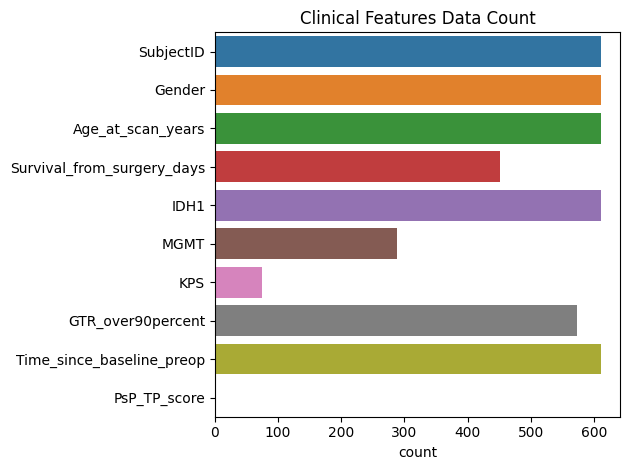

In [11]:
ax = sns.barplot(sum_clin_features_data, y=sum_clin_features_data.index, x="count")
ax.set(title= 'Clinical Features Data Count')
plt.tight_layout()
plt.savefig("ClinFeatCount.png")
plt.show()


In [12]:
display(clin_features.isna().sum())
display(clin_features.describe())
print(clin_features.shape)

SubjectID                       0
Gender                          0
Age_at_scan_years               0
Survival_from_surgery_days    159
IDH1                            0
MGMT                          322
KPS                           536
GTR_over90percent              38
Time_since_baseline_preop       0
PsP_TP_score                  611
dtype: int64

,Age_at_scan_years,Time_since_baseline_preop,PsP_TP_score
count,611.000000,611.0,0.0
mean,62.977594,0.0,NaN
std,12.424672,0.0,NaN
min,18.650000,0.0,NaN
25%,55.910000,0.0,NaN
50%,63.580000,0.0,NaN
75%,71.665000,0.0,NaN
max,88.500000,0.0,NaN


(611, 10)


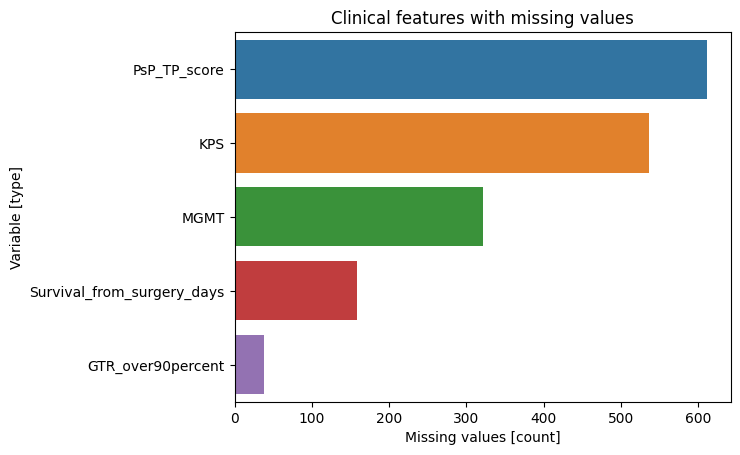

In [13]:
info_df  = pd.DataFrame(columns=['variable_name', 'missing_values', "data_type" ])
for key, data in clin_features.items():
 # Get the variable names
  names = clin_features.columns

  # Get the data types of the columns with the pandas attribute dtypes
  data_type = clin_features.dtypes

  # Compute the missing values identifying the NaN values and summing them
  missing_values = clin_features.isna().sum()

  # Create an auxiliary dataframe with the values
  df = pd.DataFrame({"variable_name": names, "data_type": data_type, "missing_values": missing_values})

  # Concatenate the auxiliary dataframe to the full dataframe
  info_df = pd.concat([info_df, df], ignore_index=True)

missing_values_df= info_df.loc[info_df['missing_values']!= 0]
missing_values_df = missing_values_df.sort_values(by="missing_values", ascending=False)
ax = sns.barplot(data=missing_values_df, y="variable_name", x="missing_values")
ax.set(xlabel='Missing values [count]', ylabel='Variable [type]', title= 'Clinical features with missing values')
plt.savefig("MissValClinFeat.png")

#its not this plot cuz many features have been removed earlier, check pptx instead

PsP_TP score has only missing data, so we remove it. Also KPS is mostly missing data, so we remove it too. We remove SubjectID because the IDs are the same. Time_since_baseline_preop is also getting removed because std is 0.

In [14]:
clin_features =clin_features.drop(["PsP_TP_score", "KPS", "SubjectID", "Time_since_baseline_preop" ] , axis=1)
rad_features.drop("SubjectID", axis =1, inplace=True)
display(clin_features.isna().sum())
print(clin_features.dtypes)

Gender                          0
Age_at_scan_years               0
Survival_from_surgery_days    159
IDH1                            0
MGMT                          322
GTR_over90percent              38
dtype: int64

Gender                         object
Age_at_scan_years             float64
Survival_from_surgery_days     object
IDH1                           object
MGMT                           object
GTR_over90percent              object
dtype: object


We remove those columns in rad_features that contain Standard Deviation ==0 because they do not help the model predict better and the create problem when doing feature selection

In [15]:
'''
print("before", rad_features.shape)
index = rad_features[rad_features["FLAIR_ED_Morphologic_PerimeterOnBorder"]!=0].index
print("index to remove", index)
rad_features = rad_features.drop(index, axis=0)
clin_features = clin_features.drop(index, axis=0)
'''
col_index = rad_features.columns[rad_features.std(axis=0)==0] #Columns where standard deviation is 0-> means unhelpful information
print("How many columns have std==0 : ", col_index.shape)
display("Column index", col_index)
rad_features = rad_features.drop(columns =col_index)
print("after", rad_features.shape)

How many columns have std==0 :  (252,)


'Column index'

Index(['FLAIR_ED_Histogram_Bins-16_Bins-16_Maximum',
       'FLAIR_ED_Histogram_Bins-16_Bins-16_Minimum',
       'FLAIR_ED_Histogram_Bins-16_Bins-16_Range',
       'FLAIR_ED_Morphologic_OrientedBoundingBoxSize_Axis-0',
       'FLAIR_ED_Morphologic_OrientedBoundingBoxSize_Axis-1',
       'FLAIR_ED_Morphologic_OrientedBoundingBoxSize_Axis-2',
       'T1_ED_Histogram_Bins-16_Bins-16_Maximum',
       'T1_ED_Histogram_Bins-16_Bins-16_Minimum',
       'T1_ED_Histogram_Bins-16_Bins-16_Range',
       'T1_ED_Morphologic_OrientedBoundingBoxSize_Axis-0',
       ...
       'T1GD_ET_Morphologic_PixelsOnBorder',
       'DSC_PH_ED_Histogram_Bins-16_Bins-16_Maximum',
       'DSC_PH_ED_Histogram_Bins-16_Bins-16_Minimum',
       'DSC_PH_ED_Histogram_Bins-16_Bins-16_Range',
       'DSC_PH_ED_Morphologic_OrientedBoundingBoxSize_Axis-0',
       'DSC_PH_ED_Morphologic_OrientedBoundingBoxSize_Axis-1',
       'DSC_PH_ED_Morphologic_OrientedBoundingBoxSize_Axis-2',
       'DSC_PH_ED_Morphologic_PerimeterOnBord

after (611, 4500)


In [16]:
col_index = rad_features.columns[rad_features.std(axis=0)==0]
print(col_index.shape)

(0,)


Dropping rows where NaN in Survival

In [17]:
#indexes where notna in Survival and GTR
indexes_keep = (clin_features["Survival_from_surgery_days"].notna())
clin_features = clin_features[indexes_keep]
rad_features = rad_features[indexes_keep]
print(clin_features.shape)
print(clin_features.head())

(452, 6)
   Gender  Age_at_scan_years Survival_from_surgery_days      IDH1 MGMT  \
1       F              61.30                        291  Wildtype  NaN   
5       M              52.99                        626  Wildtype  NaN   
7       F              55.06                        469  Wildtype  NaN   
8       M              69.12                        561  Wildtype  NaN   
10      F              39.61                        798   NOS/NEC  NaN   

   GTR_over90percent  
1                  Y  
5                  Y  
7                  Y  
8                  Y  
10                 Y  


Survival_from_surgery_days is of datatype object, so need to change to float

In [18]:
clin_features = clin_features.astype({"Survival_from_surgery_days": float})
display(clin_features.isna().sum())

Gender                          0
Age_at_scan_years               0
Survival_from_surgery_days      0
IDH1                            0
MGMT                          217
GTR_over90percent              28
dtype: int64

In [19]:
display(clin_features["Survival_from_surgery_days"].head())
display(clin_features["Survival_from_surgery_days"].describe())
print("The mean of survival is", clin_features["Survival_from_surgery_days"].describe()["mean"]/30, "months")

1     291.0
5     626.0
7     469.0
8     561.0
10    798.0
Name: Survival_from_surgery_days, dtype: float64

count     452.000000
mean      422.165929
std       355.260164
min         3.000000
25%       157.750000
50%       366.000000
75%       554.000000
max      2207.000000
Name: Survival_from_surgery_days, dtype: float64

The mean of survival is 14.072197640117993 months


Visualize missing values in clinical features

In [20]:
info_df  = pd.DataFrame(columns=['variable_name', 'missing_values', "data_type" ])
for key, data in clin_features.items():
 # Get the variable names
  names = clin_features.columns

  # Get the data types of the columns with the pandas attribute dtypes
  data_type = clin_features.dtypes

  # Compute the missing values identifying the NaN values and summing them
  missing_values = clin_features.isna().sum()

  # Create an auxiliary dataframe with the values
  df = pd.DataFrame({"variable_name": names, "data_type": data_type, "missing_values": missing_values})

  # Concatenate the auxiliary dataframe to the full dataframe
  info_df = pd.concat([info_df, df], ignore_index=True)

missing_values_df= info_df.loc[info_df['missing_values']!= 0]
missing_values_df = missing_values_df.sort_values(by="missing_values", ascending=False)

[Text(0.5, 0, 'Missing values [count]'),
 Text(0, 0.5, 'Variable [type]'),
 Text(0.5, 1.0, 'Clinical features with missing values')]

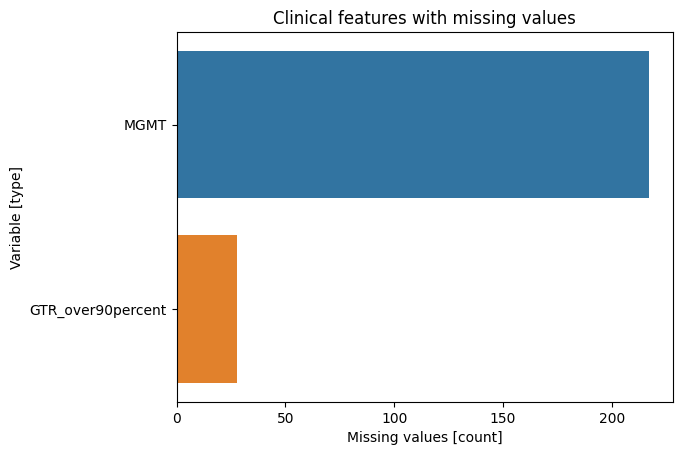

In [21]:
ax = sns.barplot(data=missing_values_df, y="variable_name", x="missing_values")
ax.set(xlabel='Missing values [count]', ylabel='Variable [type]', title= 'Clinical features with missing values')


#its not this plot cuz many features have been removed earlier, check pptx instead

##Survival Distribution

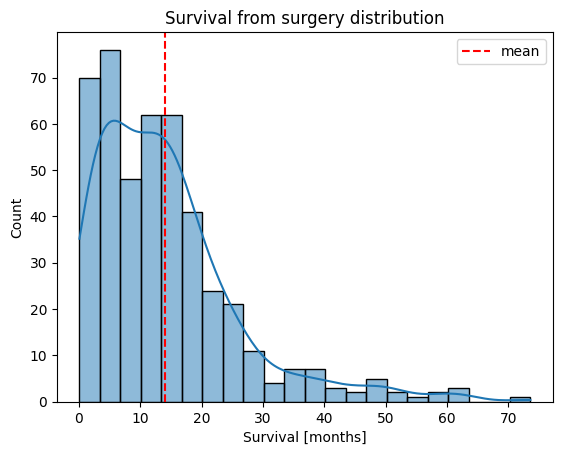

In [22]:
hist = sns.histplot(
    x=clin_features["Survival_from_surgery_days"]/30,
    kde=True
)
hist.set(xlabel='Survival [months]', ylabel='Count', title='Survival from surgery distribution')
plt.plot()
plt.axvline(x=(clin_features["Survival_from_surgery_days"]/30).mean(),
            color='red', label ="mean", ls='--')
plt.legend()
plt.savefig('SurvivalDistributionMonths.png')

In [23]:
print(422.165929/30)
clin_features["Survival_from_surgery_days"].describe()
print("mean", 423.022173/30, "months, max=", 2207/30, "months and min=", 3, "days")

14.072197633333333
mean 14.1007391 months, max= 73.56666666666666 months and min= 3 days


We have decided to convert the days in Survival_from_surgery_days into two categories. The two categories: Short survival and long survival(encompassing intermediate and long survival seen in other papers).

https://arxiv.org/pdf/1811.02629.pdf

Here they mention an accuracy of 0.6 for the top 5 approaches. Random choice would be 0.33 (3-class classification)

https://www.spiedigitallibrary.org/journals/journal-of-medical-imaging/volume-7/issue-03/031505/Overall-survival-prediction-in-glioblastoma-patients-using-structural-magnetic-resonance/10.1117/1.JMI.7.3.031505.full?SSO=1

Another paper predicting OS

print(12*30)
print(14*30)
print(720/30)


In [24]:
bins = pd.IntervalIndex.from_tuples([(0, 30*12), (30*12,clin_features["Survival_from_surgery_days"].max() )])
categories = ['short', 'long']
clin_features["Survival_from_surgery_days"] = pd.cut(clin_features["Survival_from_surgery_days"], bins=bins, labels = categories).cat.rename_categories(categories)
display(clin_features.head())

,Gender,Age_at_scan_years,Survival_from_surgery_days,IDH1,MGMT,GTR_over90percent
1,F,61.30,short,Wildtype,NaN,Y
5,M,52.99,long,Wildtype,NaN,Y
7,F,55.06,long,Wildtype,NaN,Y
8,M,69.12,long,Wildtype,NaN,Y
10,F,39.61,long,NOS/NEC,NaN,Y


In [25]:
catcol=[]
def categorise(data):
  for i in data.columns:
        if data[i].dtype == 'object' or data[i].dtype == 'bool': #turn object/string into categorical
              data[i] = pd.Categorical(data[i])
              #print(i, pd.Categorical(data[i]).categories)
              catcol.append(i)
categorise(clin_features)

for i in clin_features.columns:
  if clin_features[i].dtype == 'category':
    print(i, pd.Categorical(clin_features[i]).categories)
catcol = ["Gender", "IDH1", "MGMT", "GTR_over90percent", "Survival_from_surgery_days"]

Gender Index(['F', 'M'], dtype='object')
Survival_from_surgery_days Index(['short', 'long'], dtype='object')
IDH1 Index(['Mutated', 'NOS/NEC', 'Wildtype'], dtype='object')
MGMT Index(['Indeterminate', 'Methylated', 'Unmethylated'], dtype='object')
GTR_over90percent Index(['N', 'Y'], dtype='object')


(3, 2)
M    275
F    177
Name: Gender, dtype: int64


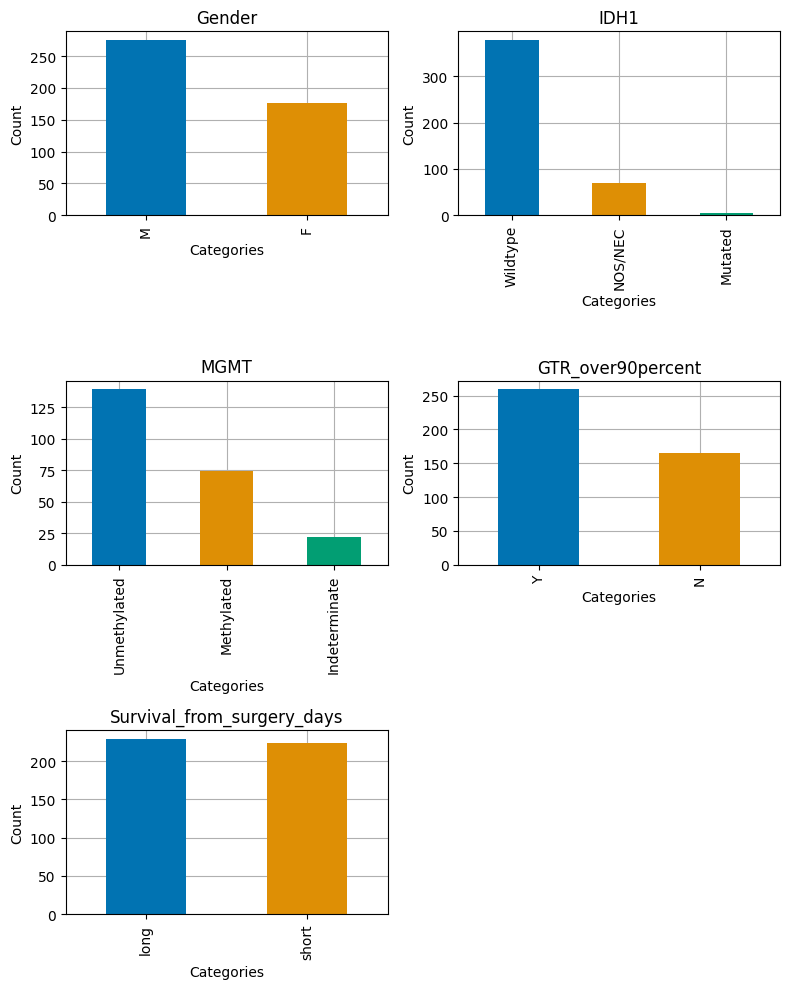

In [26]:
fig, ax = plt.subplots(3,2, figsize=(8, 10))

print(ax.shape)
print(clin_features[catcol[0]].value_counts())
colors=sns.color_palette("colorblind")
#ax[0,0].grid()
ax[0,0].set_axisbelow(True)
ax[0,0].set(xlabel="Categories", ylabel="Count", title=catcol[0])
#ax[0,0]
clin_features[catcol[0]].value_counts().plot(ax=ax[0,0], kind="bar", color=colors, grid=True)
ax[0,1].set_title(catcol[1])
ax[0,1].set_axisbelow(True)
ax[0,1].set(xlabel="Categories", ylabel="Count")
clin_features[catcol[1]].value_counts().plot(ax=ax[0,1], kind="bar", color=colors, grid=True)
ax[1,0].set_title(catcol[2])
ax[1,0].set_axisbelow(True)
ax[1,0].set(xlabel="Categories", ylabel="Count")
clin_features[catcol[2]].value_counts().plot(ax=ax[1,0], kind="bar", color=colors, grid=True)
ax[1,1].set_title(catcol[3])
ax[1,1].set_axisbelow(True)
ax[1,1].set(xlabel="Categories", ylabel="Count")
clin_features[catcol[3]].value_counts().plot(ax=ax[1,1], kind="bar", color=colors, grid=True)

ax[2,0].set_title(catcol[4])
ax[2,0].set_axisbelow(True)
ax[2,0].set(xlabel="Categories", ylabel="Count")
clin_features[catcol[4]].value_counts().plot(ax=ax[2,0], kind="bar", color=colors, grid=True)
fig.delaxes(ax[2,1])
fig.tight_layout()
plt.savefig("ClassRatios.png")
plt.show()

##Categories into Integer encoding


Each unique category value is assigned an integer value in Survival. So short becomes 0, and long becomes 1, and missing becomes -1.

In [27]:
def numberify_codes(data):
  for i in data.columns:
        if data[i].dtype == 'category':
          print("name of column", data[i].name)
          data[i] = data[i].cat.codes
  return data
display(clin_features)
clin_features_codes =numberify_codes(clin_features)
display(clin_features_codes)

,Gender,Age_at_scan_years,Survival_from_surgery_days,IDH1,MGMT,GTR_over90percent
1,F,61.30,short,Wildtype,NaN,Y
5,M,52.99,long,Wildtype,NaN,Y
7,F,55.06,long,Wildtype,NaN,Y
8,M,69.12,long,Wildtype,NaN,Y
10,F,39.61,long,NOS/NEC,NaN,Y
...,...,...,...,...,...,...
600,M,59.69,long,Wildtype,NaN,Y
601,M,77.19,short,Wildtype,Methylated,NaN
603,F,62.00,short,Wildtype,Unmethylated,NaN
608,M,29.01,short,Wildtype,Unmethylated,N


name of column Gender
name of column Survival_from_surgery_days
name of column IDH1
name of column MGMT
name of column GTR_over90percent


,Gender,Age_at_scan_years,Survival_from_surgery_days,IDH1,MGMT,GTR_over90percent
1,0,61.30,0,2,-1,1
5,1,52.99,1,2,-1,1
7,0,55.06,1,2,-1,1
8,1,69.12,1,2,-1,1
10,0,39.61,1,1,-1,1
...,...,...,...,...,...,...
600,1,59.69,1,2,-1,1
601,1,77.19,0,2,1,-1
603,0,62.00,0,2,2,-1
608,1,29.01,0,2,2,0


In [28]:
print(clin_features.shape)
print(rad_features.shape)

(452, 6)
(452, 4500)


In [29]:
print(rad_features.isna().sum())
print((rad_features.isna().sum()>0).sum())
print("How many values missing in rad_features", rad_features.isna().sum().sum())
rad_features_na= rad_features.copy()

FLAIR_ED_Intensity_CoefficientOfVariation      0
FLAIR_ED_Intensity_Energy                      0
FLAIR_ED_Intensity_InterQuartileRange          0
FLAIR_ED_Intensity_Kurtosis                    0
FLAIR_ED_Intensity_Maximum                     0
                                            ... 
DSC_PH_ED_NGTDM_Coarsness                    114
DSC_PH_ED_NGTDM_Complexity                   114
DSC_PH_ED_NGTDM_Contrast                     114
DSC_PH_ED_NGTDM_Strength                     114
DSC_PH_ED_LBP_Radius-1_Bins-16_LBP           114
Length: 4500, dtype: int64
3948
How many values missing in rad_features 259902


No more missing data in radiological features! :D

In [30]:
X = rad_features
y = clin_features["Survival_from_surgery_days"]
print("X", X.shape)
print("y", y.shape)
print(len(rad_features))

X (452, 4500)
y (452,)
452


In [31]:
X= X.dropna(thresh = len(rad_features)-20,axis=1)
display(X.shape)

(452, 1644)

#Train Test split

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
print("X_train", X_train.shape,"X_test",  X_test.shape, "y_train", y_train.shape, "y_test", y_test.shape)

X_train (339, 1644) X_test (113, 1644) y_train (339,) y_test (113,)


##Standardize Data

In [33]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_columns= X.columns
X_train = pd.DataFrame(sc.fit_transform(X_train), columns = X_columns)
X_test = pd.DataFrame(sc.transform(X_test), columns = X_columns)

##Data Imputation

In [34]:
from sklearn.impute import KNNImputer

def replace_by_imputation(X_train, X_test):
  imputer = KNNImputer(n_neighbors=25, weights="uniform")
  X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X.columns)
  X_test = pd.DataFrame(imputer.transform(X_test), columns=X.columns)
  return X_train, X_test
def replace_by_zero(X_train, X_test):
  X_train = X_train.fillna(0)
  X_test = X_test.fillna(0)
  return X_train, X_test
def replace_by_mean(X_train, X_test):
  for i in X_train.columns:
    X_train[i].fillna(X_train[i].mean(), inplace=True)
    X_test[i].fillna(X_train[i].mean(), inplace=True)
  return X_train, X_test


X_train, X_test = replace_by_imputation(X_train, X_test)


#Feature Selection

SelectKBest feature selection calculates the F-value between each feature and the target variable (in this case, y_train). It then chooses the k best features based on the F-values.

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 637  638  640  775  776  778  913  914  916 1462 1463 1465] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


selected_feature_indices [1029 1030 1062 1064 1146 1154 1164 1200 1202 1207]
selected_feature_indices.shape (10,)
scores of the selected features [18.55198122 18.8264792  18.04056311 23.11355065 19.49902678 18.22569791
 17.73686552 19.02851592 19.9923516  18.61710897]
['T2_ET_Histogram_Bins-16_Bins-16_RootMeanSquare', 'T2_ET_Histogram_Bins-16_Bins-16_SeventyFifthPercentile', 'T2_ET_GLRLM_Bins-16_Radius-1_HighGreyLevelRunEmphasis', 'T2_ET_GLRLM_Bins-16_Radius-1_LongRunHighGreyLevelEmphasis', 'T2_ED_Histogram_Bins-16_Bins-16_Bin-9_Probability', 'T2_ED_Histogram_Bins-16_Bins-16_Mean', 'T2_ED_Histogram_Bins-16_Bins-16_RootMeanSquare', 'T2_ED_GLRLM_Bins-16_Radius-1_HighGreyLevelRunEmphasis', 'T2_ED_GLRLM_Bins-16_Radius-1_LongRunHighGreyLevelEmphasis', 'T2_ED_GLRLM_Bins-16_Radius-1_ShortRunHighGreyLevelEmphasis']
Resultant dictionary is : {'T2_ET_Histogram_Bins-16_Bins-16_RootMeanSquare': 18.55198122147615, 'T2_ET_Histogram_Bins-16_Bins-16_SeventyFifthPercentile': 18.826479203806475, 'T2_ET_

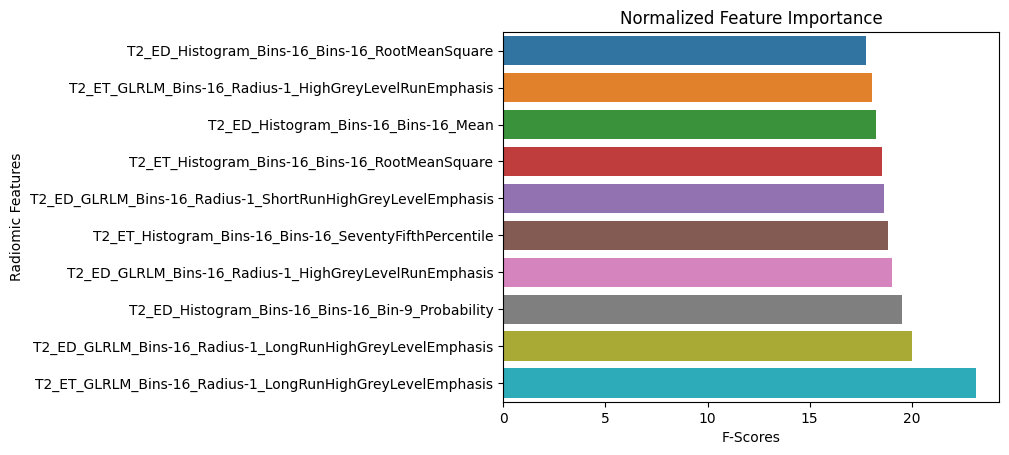

In [35]:
from sklearn.feature_selection import SelectKBest, f_classif

# X is your feature matrix and y is your target variable
# Assuming X has both categorical and numeric features

# Perform feature selection using f_classif
k = 10 # Number of top features to select
selector = SelectKBest(score_func=f_classif, k=k)
X_selected = selector.fit_transform(X_train, y_train)

# Get the indices of the selected features
selected_feature_indices = selector.get_support(indices=True)

#print indices of selected features and the shape of the selected feature array
print("selected_feature_indices", selected_feature_indices)
print("selected_feature_indices.shape", selected_feature_indices.shape)

#selected_feature_indices = np.argsort(selector.scores_)[::-1]

#Print scores of selected features
scores = selector.scores_[selected_feature_indices]
print("scores of the selected features", scores)

#sort according to score
#scores_index_sorted = np.argsort(scores)#np.argsort
#print("scores of the selected features_sorted", scores_index_sorted)

#selected_feature_indices = selected_feature_indices[scores_index_sorted]

# Get the names of the selected features
selected_features = [X_train.columns[i] for i in selected_feature_indices]
print(selected_features)

#create a dictionary and store name and score in it

# conversion of lists to dictionary
# using naive method

# initializing lists
keys = list(selected_features)#need all the names
values = list(scores) #the scores

# using naive method
# to convert lists to dictionary
unsorted_dict = {}
for key in keys:
    for value in values:
        unsorted_dict[key] = value
        values.remove(value)
        break

# Printing resultant dictionary
print("Resultant dictionary is : " + str(unsorted_dict))

#sort dictionary by values from high to low
list_sorted=sorted(unsorted_dict.items(), key=lambda item: item[1])
print('sorted list',list_sorted)
sorted_dict=dict(list_sorted)
print("sorted dictionary",sorted_dict)

#get the sorted scores and names and force them into a list
selected_features=list(sorted_dict.keys())
scores=list(sorted_dict.values())


# Print the selected features and their respective F-values
print("Selected Features:", selected_features)

#plt.barh(selected_features, scores, align='center')
sns.barplot(x=scores, y=selected_features)
plt.xlabel("F-Scores")
plt.ylabel("Radiomic Features")
plt.title("Normalized Feature Importance")
plt.rcParams.update({'font.size': 14})
plt.savefig("NormalizedFeatureImportance.png", bbox_inches='tight')
#select those features for X_train and X_test
X_train = X_train[selected_features]
X_test = X_test[selected_features]
plt.show()

#Hyperparameter Tuning

This is stratified because default for GridSearchCV is to do stratifiedKFold if the estimator is a classifier and y is binary.

In [45]:
bestparametermodels = {}

##K-nn Classifier

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters:  {'n_neighbors': 9, 'weights': 'uniform'}
KNeighborsClassifier(n_neighbors=9)
              precision    recall  f1-score   support

           0       0.58      0.46      0.51        56
           1       0.56      0.67      0.61        57

    accuracy                           0.57       113
   macro avg       0.57      0.57      0.56       113
weighted avg       0.57      0.57      0.56       113



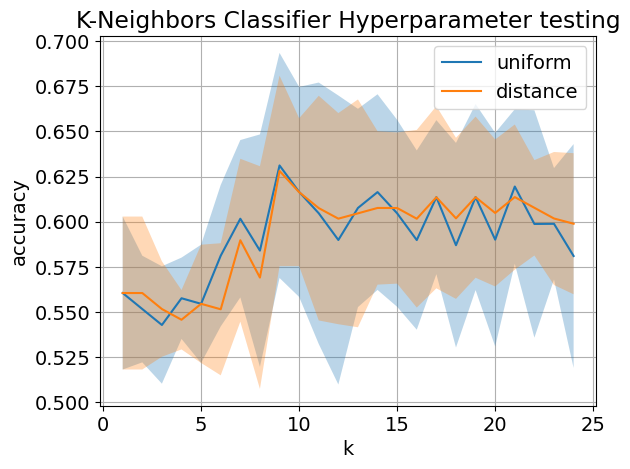

KNeighborsClassifier(n_neighbors=9)
0.5663716814159292


In [46]:
#Hyperparametertesting KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# defining parameter range
k=25
param_grid = {'n_neighbors': [i for i in range(1, k, 1)],
              'weights': ['uniform', 'distance']}

cv=5
grid = GridSearchCV(KNeighborsClassifier(), param_grid, refit = True, verbose = 1, cv=cv)

# fitting the model for grid search
grid.fit(X_train, y_train)

# print best parameter after tuning
print("Best parameters: ", grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

grid_predictions = grid.predict(X_test)

# print classification report
print(classification_report(y_test, grid_predictions, ))

results_df = pd.DataFrame(grid.cv_results_)
results_df = results_df.set_index(
    results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("n_neighbors_weights")
#display(results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]])
uniform_acc = np.array([results_df['mean_test_score'][i] for i in range(0,len(results_df), 2)])
std_uniform = np.array([results_df["std_test_score"][i] for i in range(0,len(results_df), 2)])
distance_acc = np.array([results_df['mean_test_score'][i] for i in range(1,len(results_df), 2)])
std_distance = np.array([results_df["std_test_score"][i] for i in range(1,len(results_df), 2)])

#plt.plot(uniform_acc, label="uniform")
x = np.arange(1, k)
# Plotting the uniform data with error bars
plt.plot(x, uniform_acc, label="uniform")
plt.fill_between(x, uniform_acc - std_uniform, uniform_acc + std_uniform, alpha=0.3)

plt.plot(x, distance_acc, label="distance")
plt.fill_between(x, distance_acc - std_distance, distance_acc + std_distance, alpha=0.3)

#plt.errorbar(x=np.arange(1, k), y=uniform_acc, yerr=std_uniform, label="uniform")
#plt.errorbar(x=np.arange(1, k), y=distance_acc, yerr=std_distance, label="distance")
#plt.plot(distance_acc, label="distance")
plt.legend()
plt.xlabel('k')
# We are setting the label for the y-axis as 'accuracy'.
plt.ylabel('accuracy')
plt.title("K-Neighbors Classifier Hyperparameter testing")
plt.rc('axes', axisbelow=True)
plt.grid()
#plt.xticks([i for i in range(0, k, 10)])
plt.savefig("KnClassifierHyperparameterTuning.png")
plt.show()

#How well do these hyperparameters make the model improve on our train test split?
print(grid.best_estimator_)
clf = grid.best_estimator_
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))
bestparametermodels["KNeighborsClassifier"]= grid.best_estimator_

We use the Elbow method to choose the best hyperparameter for KNeighborsClassifier. So k with best accuracy and lowest std. In this case k=6

##Logistic Regression

In [47]:
# defining parameter range
param_grid = {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, num=10),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000, 2500, 3000]
    }

grid = GridSearchCV(LogisticRegression(), param_grid, refit = True, verbose = 1)

# fitting the model for grid search
grid.fit(X_train, y_train)

# print best parameter after tuning
print("Best parameters: ", grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

grid_predictions = grid.predict(X_test)

# print classification report
print(classification_report(y_test, grid_predictions))
bestparametermodels["LogisticRegression"]= grid.best_estimator_

Fitting 5 folds for each of 800 candidates, totalling 4000 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: Futur

Best parameters:  {'C': 0.000774263682681127, 'max_iter': 100, 'penalty': 'none', 'solver': 'saga'}
LogisticRegression(C=0.000774263682681127, penalty='none', solver='saga')
              precision    recall  f1-score   support

           0       0.56      0.62      0.59        56
           1       0.58      0.51      0.54        57

    accuracy                           0.57       113
   macro avg       0.57      0.57      0.57       113
weighted avg       0.57      0.57      0.56       113



/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
1800 fits failed out of a total of 4000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: 

In [48]:
best_clf = bestparametermodels["LogisticRegression"]
best_clf.fit(X_train, y_train)
print(best_clf.score(X_test, y_test))

0.5663716814159292
0.5663716814159292


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


##SVC

In [49]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma' : ['scale', 'auto'],
              #'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['linear']  #‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’
             }

grid = GridSearchCV(SVC(probability=True), param_grid, refit = True, verbose = 1)

# fitting the model for grid search
grid.fit(X_train, y_train)

# print best parameter after tuning
print("Best parameters: ", grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

grid_predictions = grid.predict(X_test)

# print classification report
print(classification_report(y_test, grid_predictions))
bestparametermodels["SVC"]= grid.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters:  {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
SVC(C=1, kernel='linear', probability=True)
              precision    recall  f1-score   support

           0       0.55      0.64      0.60        56
           1       0.58      0.49      0.53        57

    accuracy                           0.57       113
   macro avg       0.57      0.57      0.56       113
weighted avg       0.57      0.57      0.56       113



##Random Forest Classifier

In [50]:
param_grid = {
    'n_estimators': [25, 50, 100, 150],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [3, 6, 9],
}
grid = GridSearchCV(RandomForestClassifier(), param_grid, refit = True, verbose = 1)

# fitting the model for grid search
grid.fit(X_train, y_train)

# print best parameter after tuning
print("Best parameters: ", grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

grid_predictions = grid.predict(X_test)

# print classification report
print(classification_report(y_test, grid_predictions))
bestparametermodels["RandomForestClassifier"]= grid.best_estimator_

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters:  {'max_depth': 6, 'max_features': 'log2', 'max_leaf_nodes': 9, 'n_estimators': 25}
RandomForestClassifier(max_depth=6, max_features='log2', max_leaf_nodes=9,
                       n_estimators=25)
              precision    recall  f1-score   support

           0       0.54      0.45      0.49        56
           1       0.54      0.63      0.58        57

    accuracy                           0.54       113
   macro avg       0.54      0.54      0.54       113
weighted avg       0.54      0.54      0.54       113



In [59]:
print(bestparametermodels)
display(pd.DataFrame.from_dict([bestparametermodels]))
#print(pd.DataFrame(bestparametermodels))

#print(pd.DataFrame(bestparametermodels).to_latex())

{'KNeighborsClassifier': KNeighborsClassifier(n_neighbors=9), 'LogisticRegression': LogisticRegression(C=0.000774263682681127, penalty='none', solver='saga'), 'SVC': SVC(C=1, kernel='linear', probability=True), 'RandomForestClassifier': RandomForestClassifier(max_depth=6, max_features='log2', max_leaf_nodes=9,
                       n_estimators=25)}


,KNeighborsClassifier,LogisticRegression,SVC,RandomForestClassifier
0,KNeighborsClassifier(n_neighbors=9),"LogisticRegression(C=0.000774263682681127, pen...","SVC(C=1, kernel='linear', probability=True)","(DecisionTreeClassifier(max_depth=6, max_featu..."


#Machine Learning

Here we train the 4 models we chose on our training set and test it on our test set after having done hyperparameter tuning for our models on our training set.

In [60]:
# Look at some additional evaluation metrics
def eval_Performance(y_eval, X_eval, clf):

    y_pred = clf.predict(X_eval)
    y_pred_proba = clf.predict_proba(X_eval)[:, 1]
    tn, fp, fn, tp = confusion_matrix(y_eval, y_pred).ravel()

    # Evaluation
    accuracy  = accuracy_score(y_eval, y_pred)
    precision = precision_score(y_eval, y_pred)
    recall    = recall_score(y_eval, y_pred)
    f1        = f1_score(y_eval, y_pred)
    fp_rates, tp_rates, _ = roc_curve(y_eval, y_pred_proba)

    # Calculate the area under the roc curve using a sklearn function
    roc_auc = auc(fp_rates, tp_rates)

    return accuracy, precision, recall, f1, roc_auc

In [61]:

'''
models = {
  "SVC" : SVC(C=0.1, kernel='linear', probability=True),
  "Logistic Reggression" : LogisticRegression(C=0.0006951927961775605, solver='liblinear'),
  "KNeighborsClassifier" : KNeighborsClassifier(n_neighbors=17),
  "RandomForestClassifier" : RandomForestClassifier(max_depth=3, max_leaf_nodes=3, n_estimators=150)
}
'''


df_performance_test = pd.DataFrame(columns = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'] )
df_performance_train = pd.DataFrame(columns = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'] )

for i, model_name in enumerate(bestparametermodels):
  model = bestparametermodels[model_name]
  model.fit(X_train, y_train)
  df_performance_train.loc["Train " + model_name,:] = eval_Performance(y_train, X_train, model)
  df_performance_test.loc["Test " + model_name,:] = eval_Performance(y_test, X_test, model)
display("Predicting Survival")
display(df_performance_test)
display(df_performance_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


'Predicting Survival'

,accuracy,precision,recall,f1,roc_auc
Test KNeighborsClassifier,0.566372,0.558824,0.666667,0.608,0.58067
Test LogisticRegression,0.566372,0.58,0.508772,0.542056,0.597118
Test SVC,0.566372,0.583333,0.491228,0.533333,0.595865
Test RandomForestClassifier,0.539823,0.539683,0.596491,0.566667,0.547149


,accuracy,precision,recall,f1,roc_auc
Train KNeighborsClassifier,0.675516,0.678161,0.686047,0.682081,0.727615
Train LogisticRegression,0.643068,0.66242,0.604651,0.632219,0.703488
Train SVC,0.628319,0.64557,0.593023,0.618182,0.699624
Train RandomForestClassifier,0.731563,0.721311,0.767442,0.743662,0.8268


Turning the table into latex so it can be used in our overleaf project :)

In [63]:
display(df_performance_test.astype(float).round(decimals=2))
print(df_performance_test.astype(float).round(decimals=2).to_latex())
display(df_performance_train.astype(float).round(decimals=2))
print(df_performance_train.astype(float).round(decimals=2).to_latex())

,accuracy,precision,recall,f1,roc_auc
Test KNeighborsClassifier,0.57,0.56,0.67,0.61,0.58
Test LogisticRegression,0.57,0.58,0.51,0.54,0.60
Test SVC,0.57,0.58,0.49,0.53,0.60
Test RandomForestClassifier,0.54,0.54,0.60,0.57,0.55


\begin{tabular}{lrrrrr}
\toprule
{} &  accuracy &  precision &  recall &    f1 &  roc\_auc \\
\midrule
Test KNeighborsClassifier   &      0.57 &       0.56 &    0.67 &  0.61 &     0.58 \\
Test LogisticRegression     &      0.57 &       0.58 &    0.51 &  0.54 &     0.60 \\
Test SVC                    &      0.57 &       0.58 &    0.49 &  0.53 &     0.60 \\
Test RandomForestClassifier &      0.54 &       0.54 &    0.60 &  0.57 &     0.55 \\
\bottomrule
\end{tabular}



<ipython-input-63-f1474f44adf8>:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_performance_test.astype(float).round(decimals=2).to_latex())


,accuracy,precision,recall,f1,roc_auc
Train KNeighborsClassifier,0.68,0.68,0.69,0.68,0.73
Train LogisticRegression,0.64,0.66,0.60,0.63,0.70
Train SVC,0.63,0.65,0.59,0.62,0.70
Train RandomForestClassifier,0.73,0.72,0.77,0.74,0.83


\begin{tabular}{lrrrrr}
\toprule
{} &  accuracy &  precision &  recall &    f1 &  roc\_auc \\
\midrule
Train KNeighborsClassifier   &      0.68 &       0.68 &    0.69 &  0.68 &     0.73 \\
Train LogisticRegression     &      0.64 &       0.66 &    0.60 &  0.63 &     0.70 \\
Train SVC                    &      0.63 &       0.65 &    0.59 &  0.62 &     0.70 \\
Train RandomForestClassifier &      0.73 &       0.72 &    0.77 &  0.74 &     0.83 \\
\bottomrule
\end{tabular}



<ipython-input-63-f1474f44adf8>:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_performance_train.astype(float).round(decimals=2).to_latex())


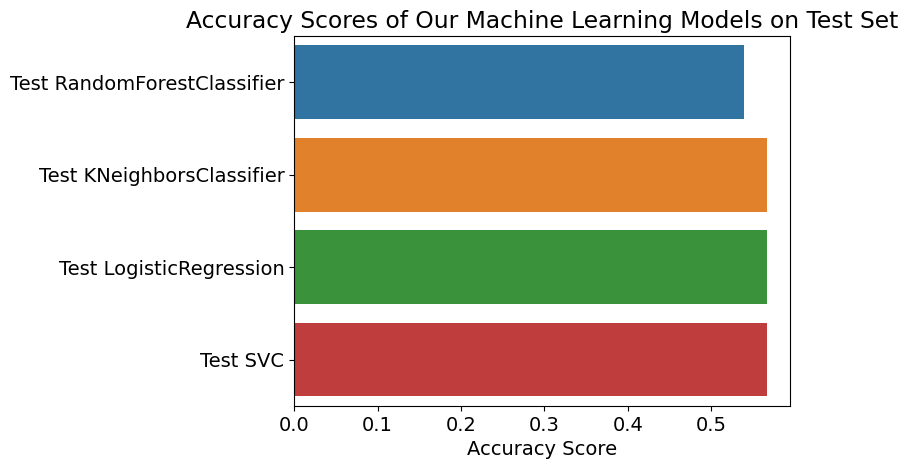

In [64]:
plt.rcParams.update({'font.size': 14})
plt.tight_layout()
modelnames = [str(model) for model in bestparametermodels]
indices_sorted = np.argsort(df_performance_test["accuracy"])
model_acc = pd.DataFrame(df_performance_test["accuracy"].iloc[indices_sorted])


#plt.barh(model_acc.index, model_acc["accuracy"])
sns.barplot(x=model_acc["accuracy"], y=model_acc.index)
plt.xlabel('Accuracy Score')
plt.title('Accuracy Scores of Our Machine Learning Models on Test Set')
plt.savefig("MLPerformances", bbox_inches='tight')
plt.show()

#Feature Importances

The feature importances of the 10 features for Logistic Regression. The higher the numbers the more important.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[0.34180369 1.25580728 0.0302139  0.1166777  0.04193942 0.7565701
 0.1011927  0.39546792 0.29385839 1.33062918]
sorted indices [2 4 6 3 8 0 7 5 1 9]


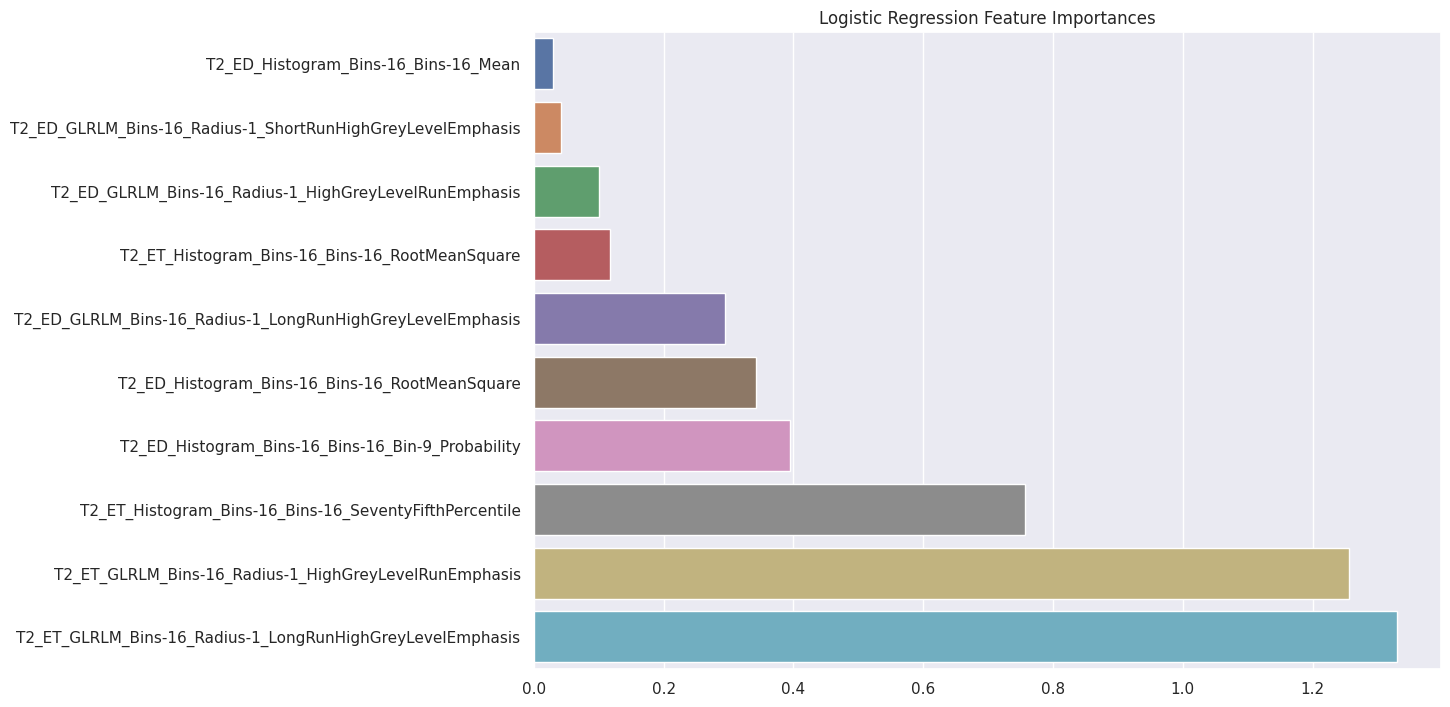

In [65]:
clf = bestparametermodels["LogisticRegression"]
clf.fit(X_train, y_train)
coefficients = np.abs(clf.coef_[0])
print(coefficients)

sorted_indices = coefficients.argsort()
print("sorted indices", sorted_indices)
sorted_feature_names = X_train.columns[sorted_indices]
sorted_importances = coefficients[sorted_indices]

sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.title("Logistic Regression Feature Importances")
sns.barplot(x= sorted_importances, y= sorted_feature_names)
plt.savefig("LogisticRegressionFeatureImportances.png")

array([0.185529  , 1.05112877, 0.08248551, 0.0284661 , 0.07003771,
       0.52897816, 0.09179158, 0.57603137, 0.22796873, 1.29930363])

sorted indices [3 4 2 6 0 8 5 7 1 9]


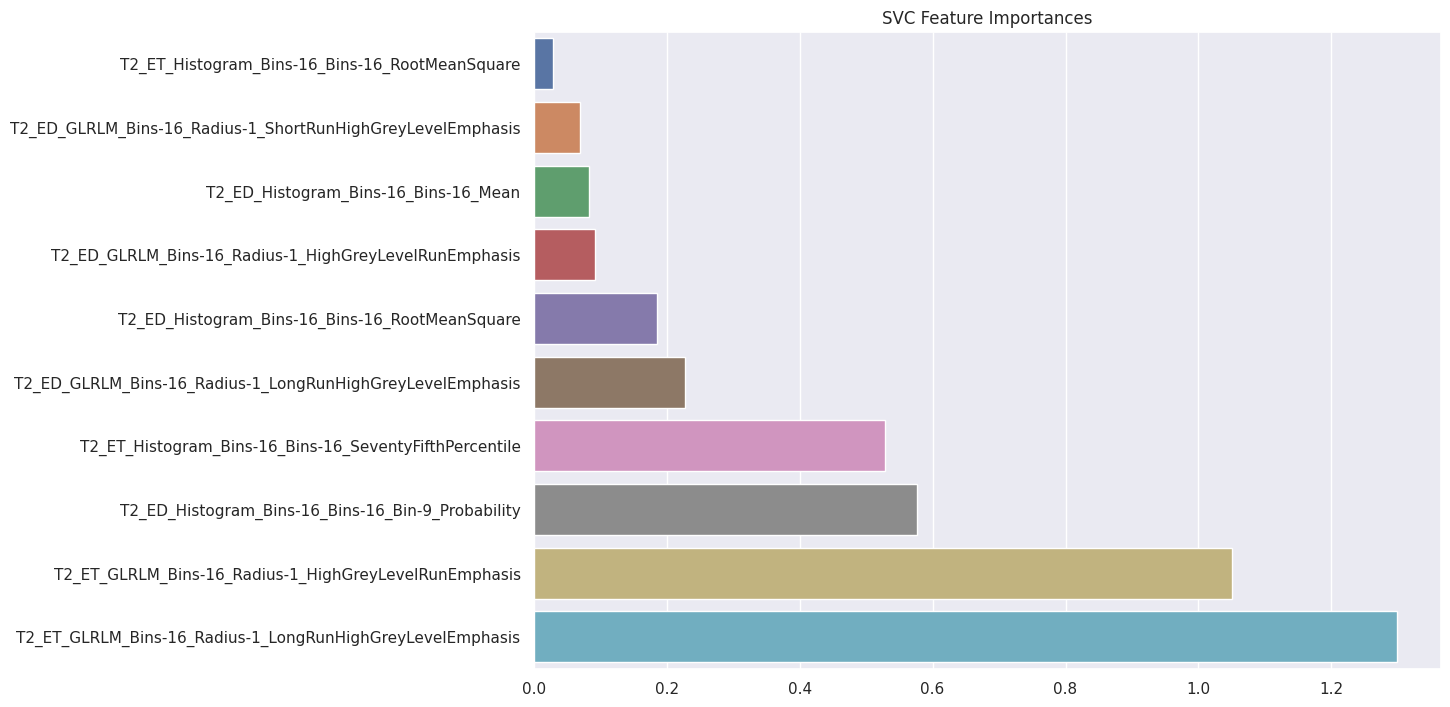

In [66]:
clf = bestparametermodels["SVC"]
clf.fit(X_train, y_train)
coefficients = np.abs(clf.coef_[0])
display(coefficients)

sorted_indices = coefficients.argsort()
print("sorted indices", sorted_indices)
sorted_feature_names = X_train.columns[sorted_indices]
sorted_importances = coefficients[sorted_indices]

sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.title("SVC Feature Importances")
sns.barplot(x= sorted_importances, y= sorted_feature_names)
plt.savefig("SVCFeatureImportances.png")

<Figure size 1500x1000 with 0 Axes>

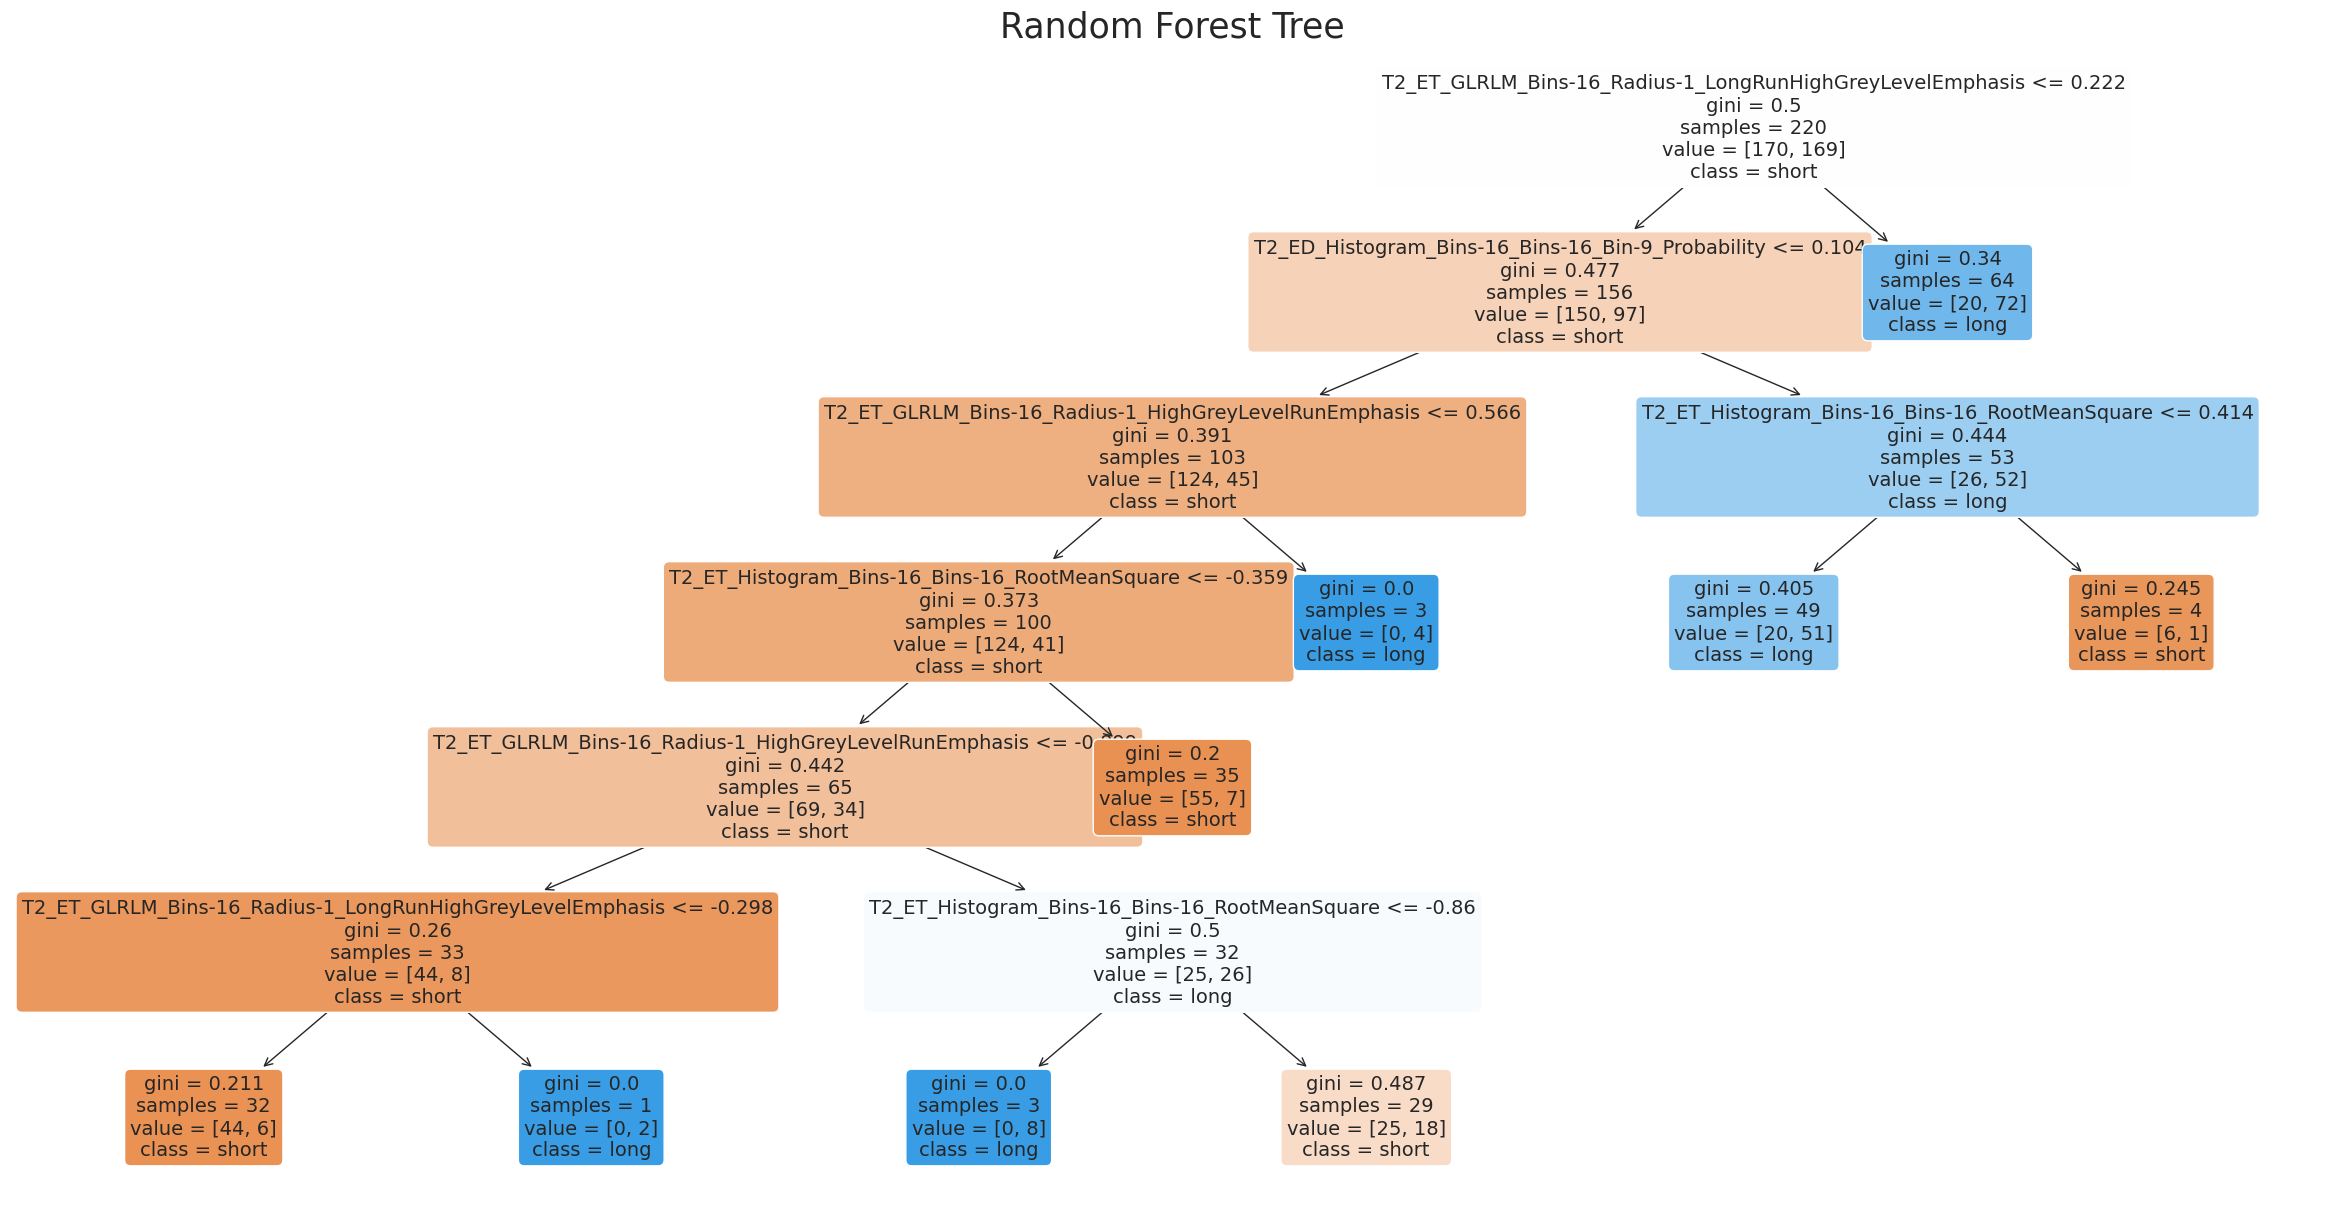

In [86]:
from sklearn import tree

clf = bestparametermodels["RandomForestClassifier"]
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
categories = ['short', 'long']
fig = plt.figure(figsize=(15, 10))

# plot tree
plt.figure(figsize=(30,15))
tree.plot_tree(clf.estimators_[0],
          feature_names=X_train.columns,
          class_names=categories,
          filled=True, impurity=True,
          rounded=True, fontsize=14)
plt.title("Random Forest Tree", fontsize=25)
plt.savefig('RandomForestTree.png')
plt.show()